## Solucion: Estudio de sistema de deteccion de agua (Reto de fuente *Kaggle*)

#### Procedamos con la carga de algunos 

In [52]:
# pip install statsmodels
# pip install colorama
# pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model  import ARIMA
from colorama import Fore
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings # Supress warnings 
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from prophet import Prophet

warnings.filterwarnings('ignore')

np.random.seed(7)


#### Procedemos a realizar la carga de los datos

In [53]:
# Especifica la ruta completa a tu archivo
df= pd.read_csv('Aquifer_Petrignano.csv')

# observavion inicial de la data
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


Procedamos a eliminar filas antiguas y eliminar columnas no útiles

In [54]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

Vamos a ajustar los nombres por unos sin mayusculas

In [55]:

df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Dado que se trata de un problema de series temporales, tenemos que la columna *date* y volverla en formato fecha

In [56]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


#### Procedamos a realizar un EDA rapido junto al estudio de las series


En base a la naturaleza del problema tenemos las siguientes variables:

+ $Lluvia$: indica la cantidad de lluvia caída
+ $Temperatura$: indica la temperatura
+ $Volumen$: indica el volumen de agua tomada de la planta potabilizadora
+ $Hidrometria$: indica el nivel de las aguas subterráneas (m)

Y el objetivo del mismo es, estudiar la variable $profundidad de las aguas subterráneas$, la cual indica el nivel de las aguas subterráneas (m desde el suelo)

Procedamos con los la descripcion de los estadisticos

In [57]:
# Estadisticos
df.describe()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
count,4199,4199.000000,4172.000000,4199.000000,4198.000000,4199.000000
mean,2014-10-01 00:00:00,1.556633,-25.182534,15.030293,-28669.156619,2.372517
min,2009-01-01 00:00:00,0.000000,-33.710000,-3.700000,-41890.176000,0.000000
25%,2011-11-16 12:00:00,0.000000,-26.860000,8.800000,-31082.832000,2.100000
50%,2014-10-01 00:00:00,0.000000,-25.170000,14.700000,-28389.744000,2.400000
75%,2017-08-15 12:00:00,0.100000,-23.270000,21.400000,-26042.904000,2.700000
max,2020-06-30 00:00:00,67.300000,-19.100000,33.000000,0.000000,4.100000
std,NaN,5.217923,2.945074,7.794871,4570.686434,0.589088


In [58]:
# Información sobre los datos:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  4199 non-null   datetime64[ns]
 1   rainfall              4199 non-null   float64       
 2   depth_to_groundwater  4172 non-null   float64       
 3   temperature           4199 non-null   float64       
 4   drainage_volume       4198 non-null   float64       
 5   river_hydrometry      4199 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 197.0 KB


La informacion anterior revela que las variables *deptg_to_groundwater* y *drainage_volume* poseen datos perdidos. Para completar estos datos, intuitinamente podemos usar el comando *.ffill()*, el cual permite rellenar los valores faltantes (NaN) en un DataFrame o Series replicando el último valor válido observado.

Ahora con este proceso veamos el grafico de los valores

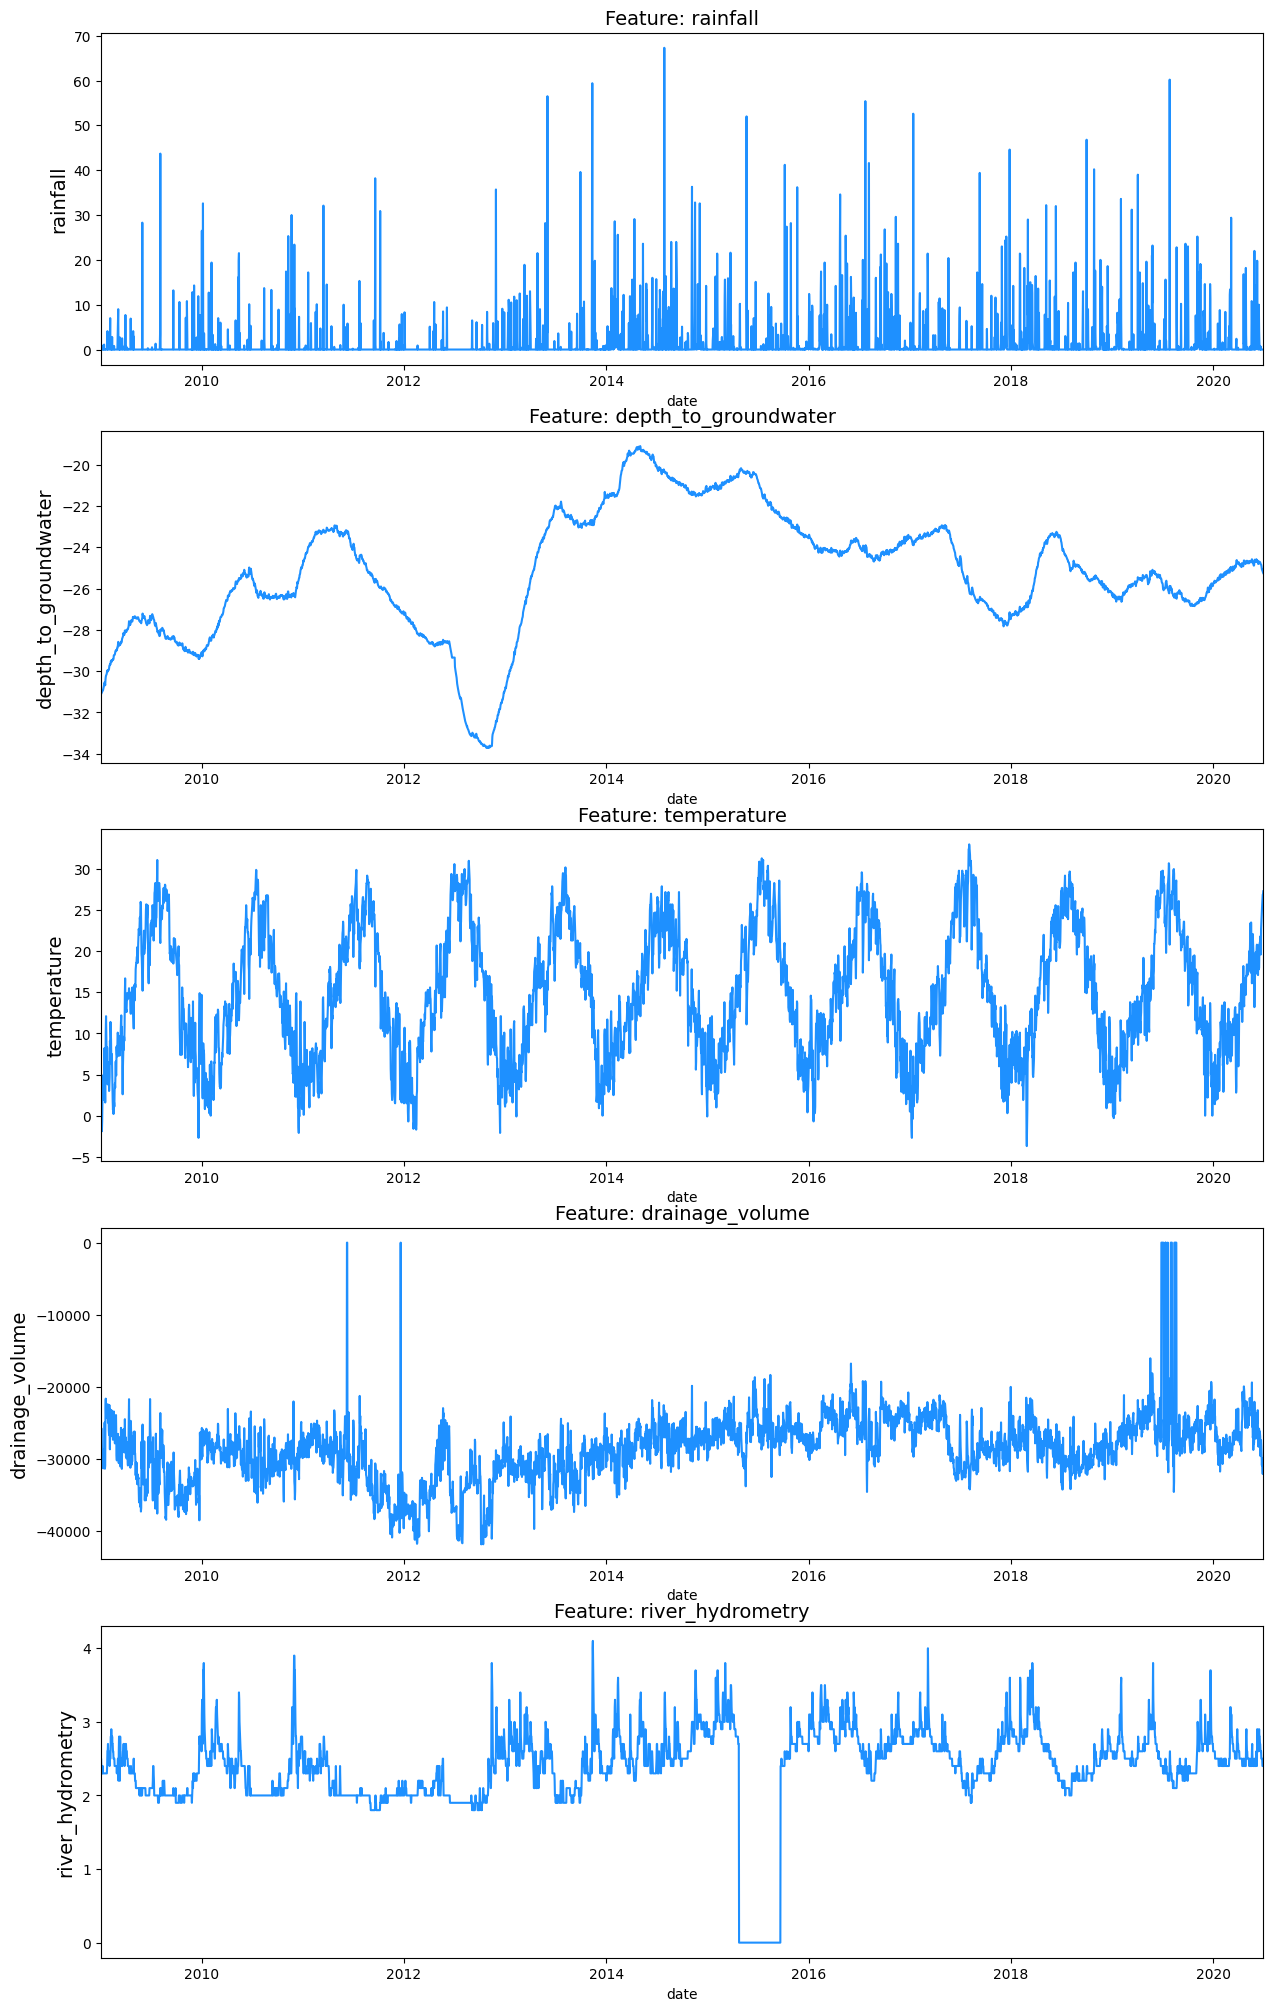

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])   

(np.float64(14245.0), np.float64(18443.0))

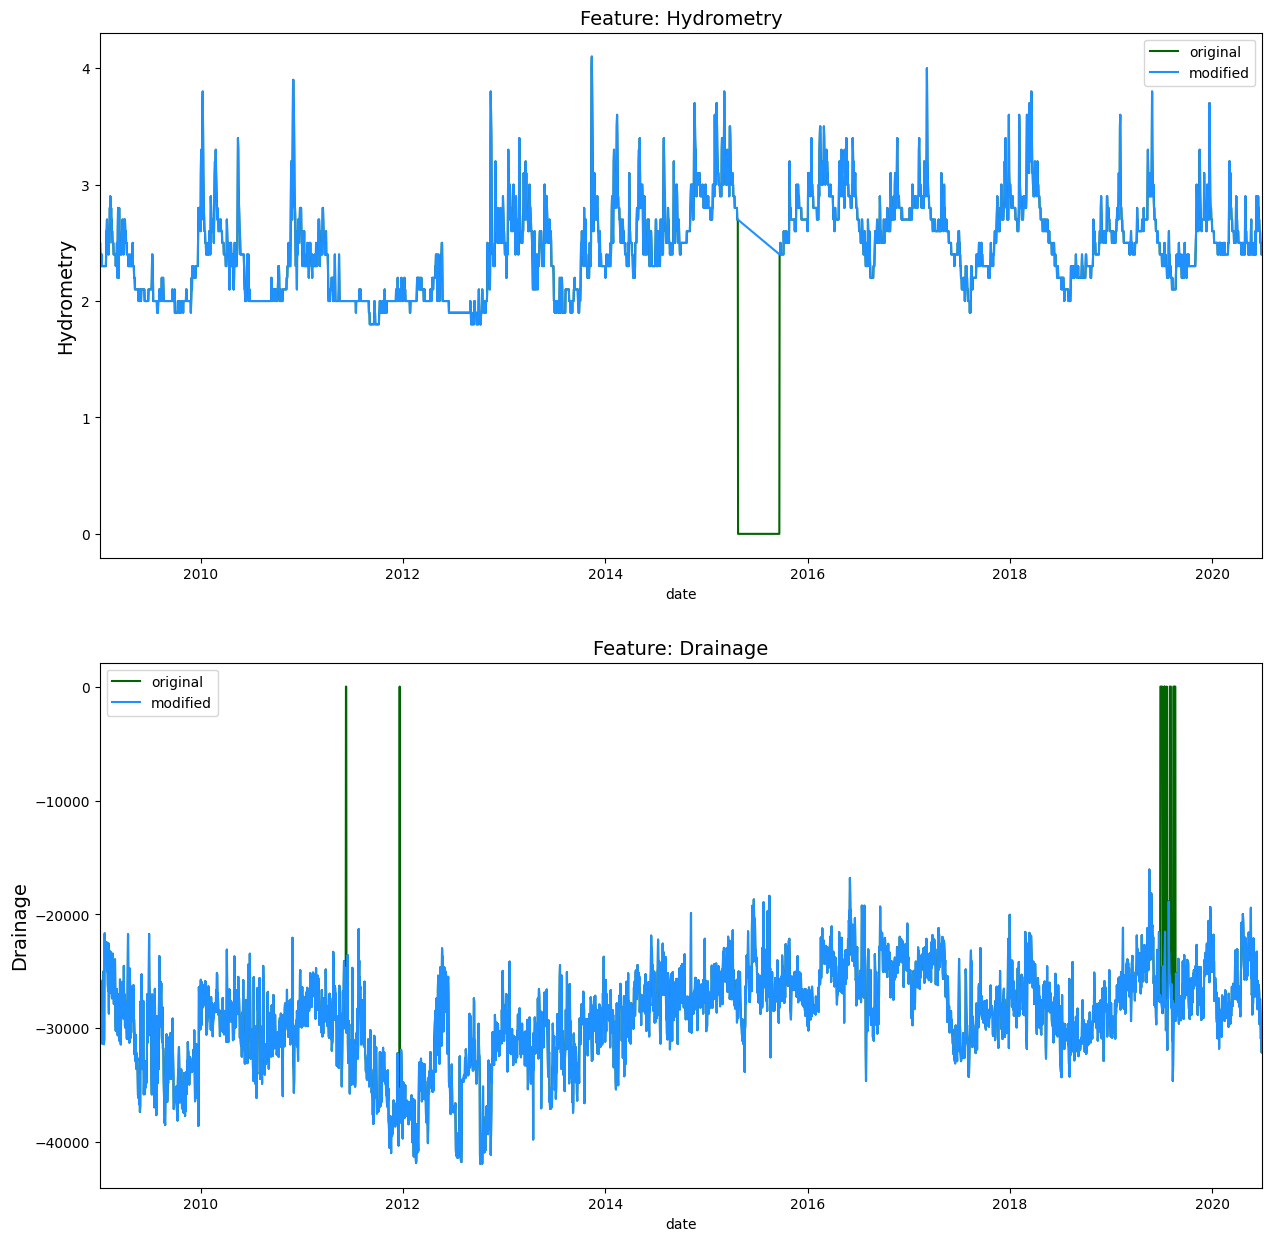

In [60]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkgreen', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkgreen', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

array([[<Axes: title={'center': 'rainfall'}>,
        <Axes: title={'center': 'depth_to_groundwater'}>],
       [<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'drainage_volume'}>],
       [<Axes: title={'center': 'river_hydrometry'}>, <Axes: >]],
      dtype=object)

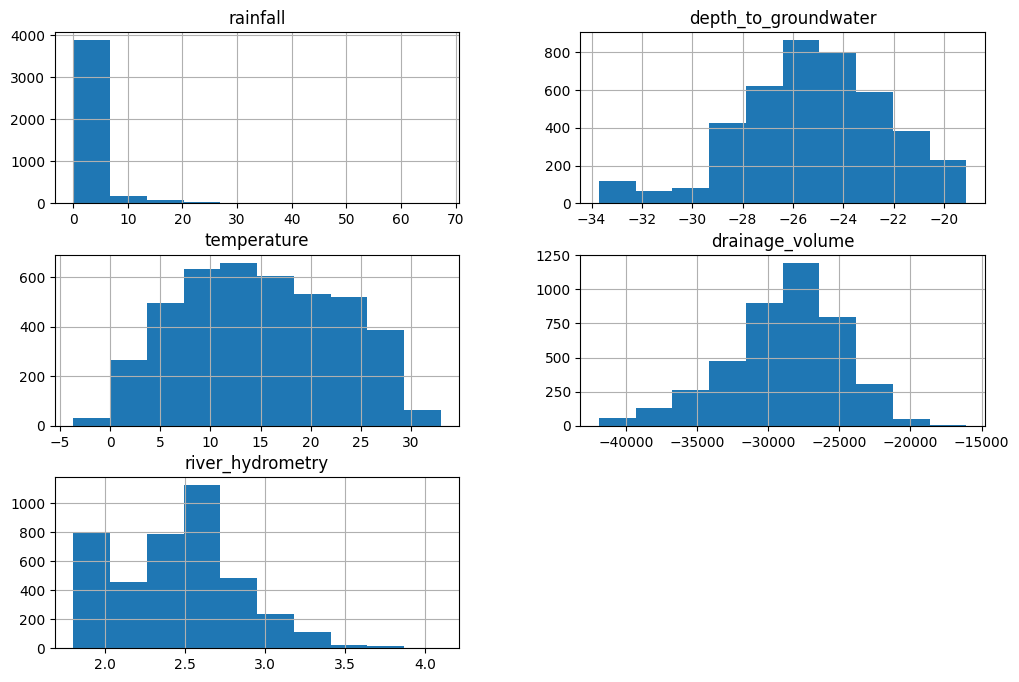

In [61]:
# Define las columnas para los gráficos (sin 'date')
cols_to_plot = df.columns.tolist()
cols_to_plot.remove('date')

# Histogramas
df[cols_to_plot].hist(figsize=(12, 8))

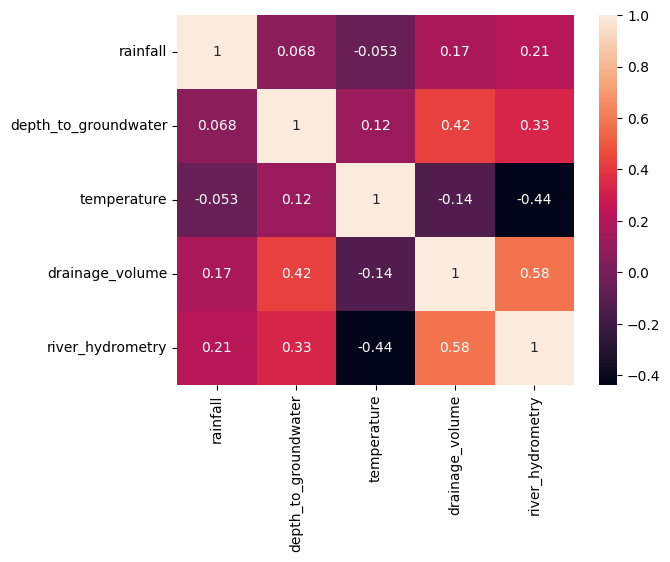

In [62]:
# Seleccionar las columnas numéricas, excluyendo 'date'
numeric_cols = df.select_dtypes(include=['number']).columns

# Calcular la matriz de correlación
corr_matrix = df[numeric_cols].corr()

# Visualizar la matriz de correlación como un mapa de calor
sns.heatmap(corr_matrix, annot=True)
plt.show()

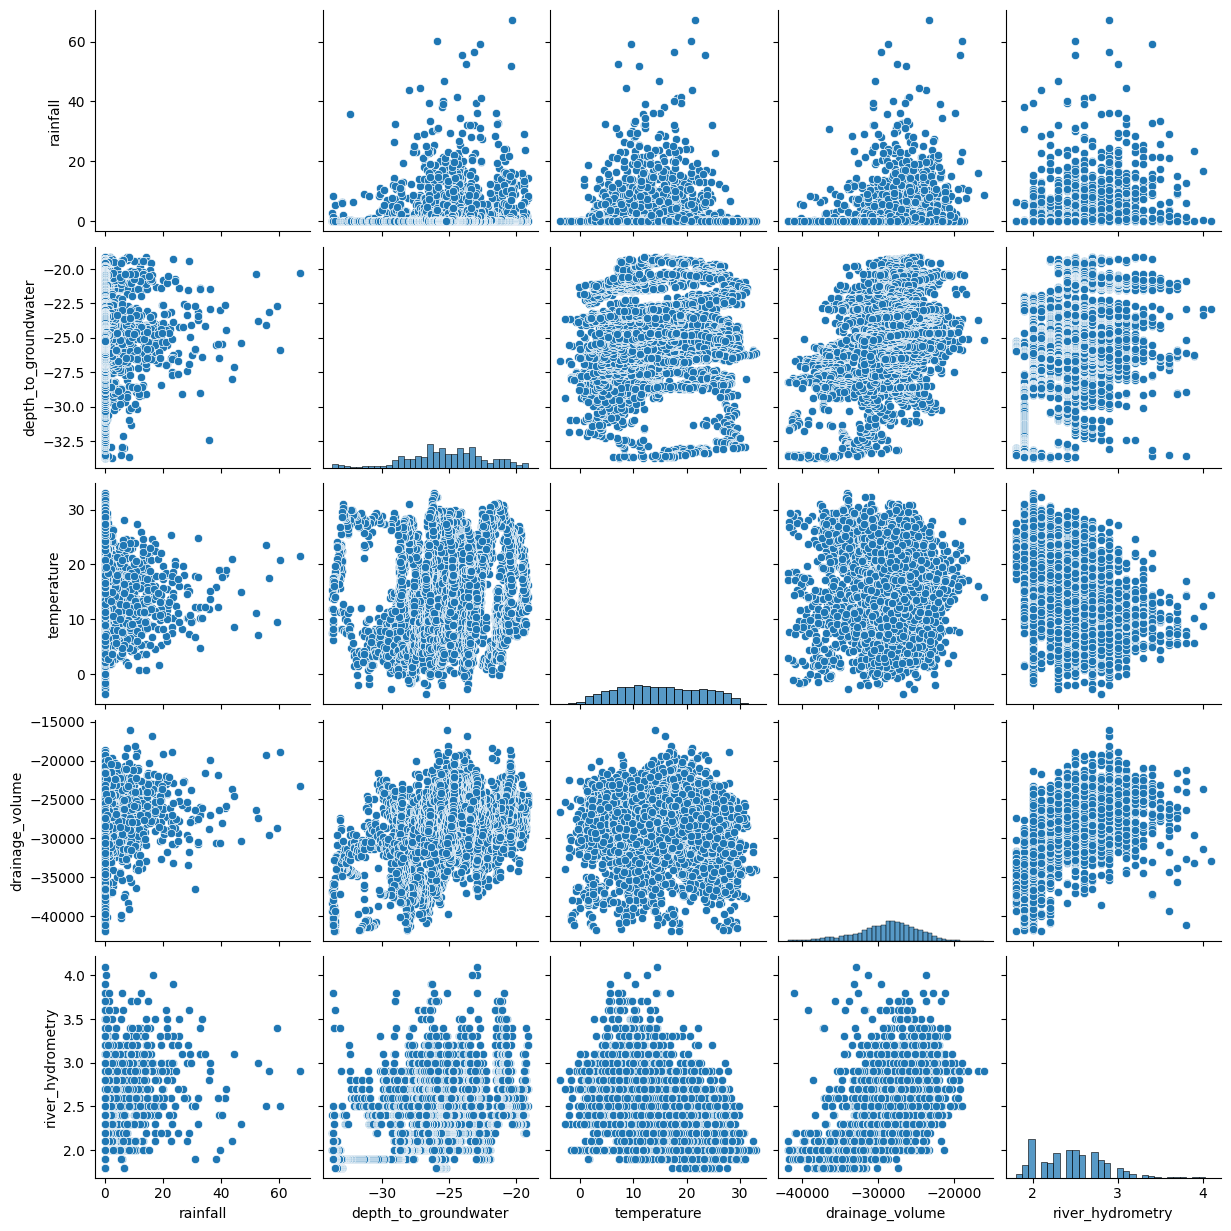

In [63]:
sns.pairplot(df)

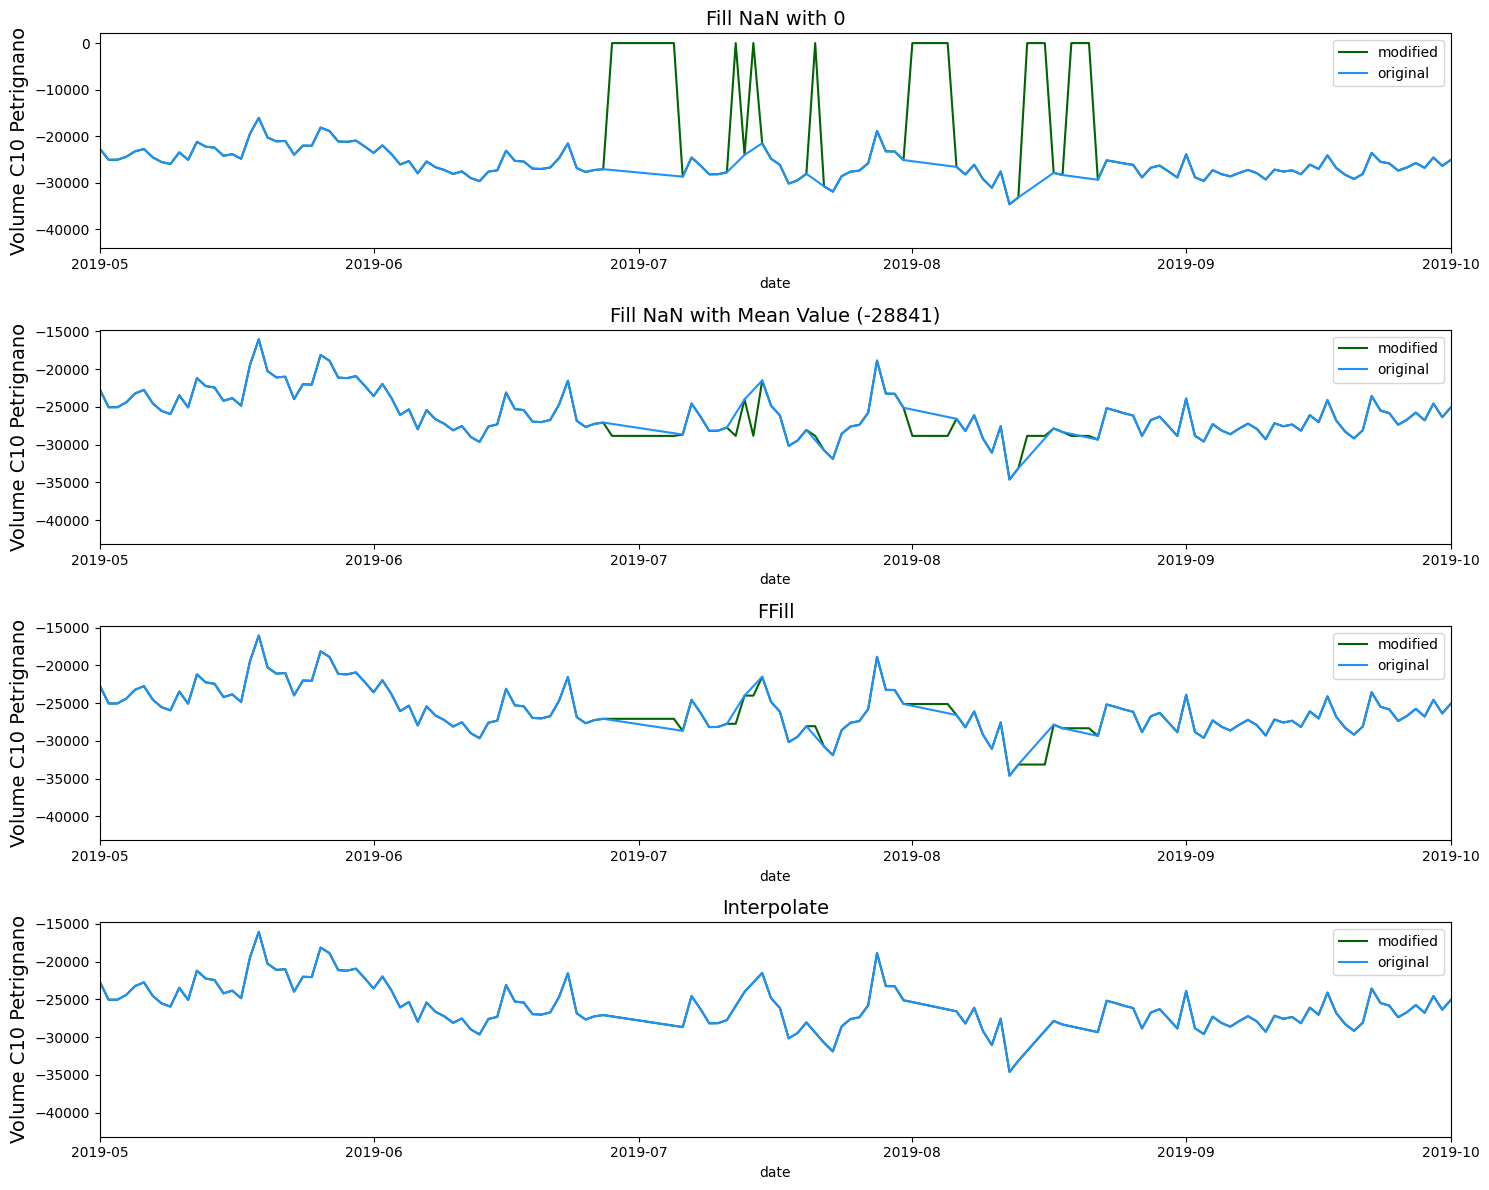

In [64]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkgreen', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkgreen', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkgreen', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkgreen', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

In [65]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

Analisis de la serie de tiempo

Estacionaridad

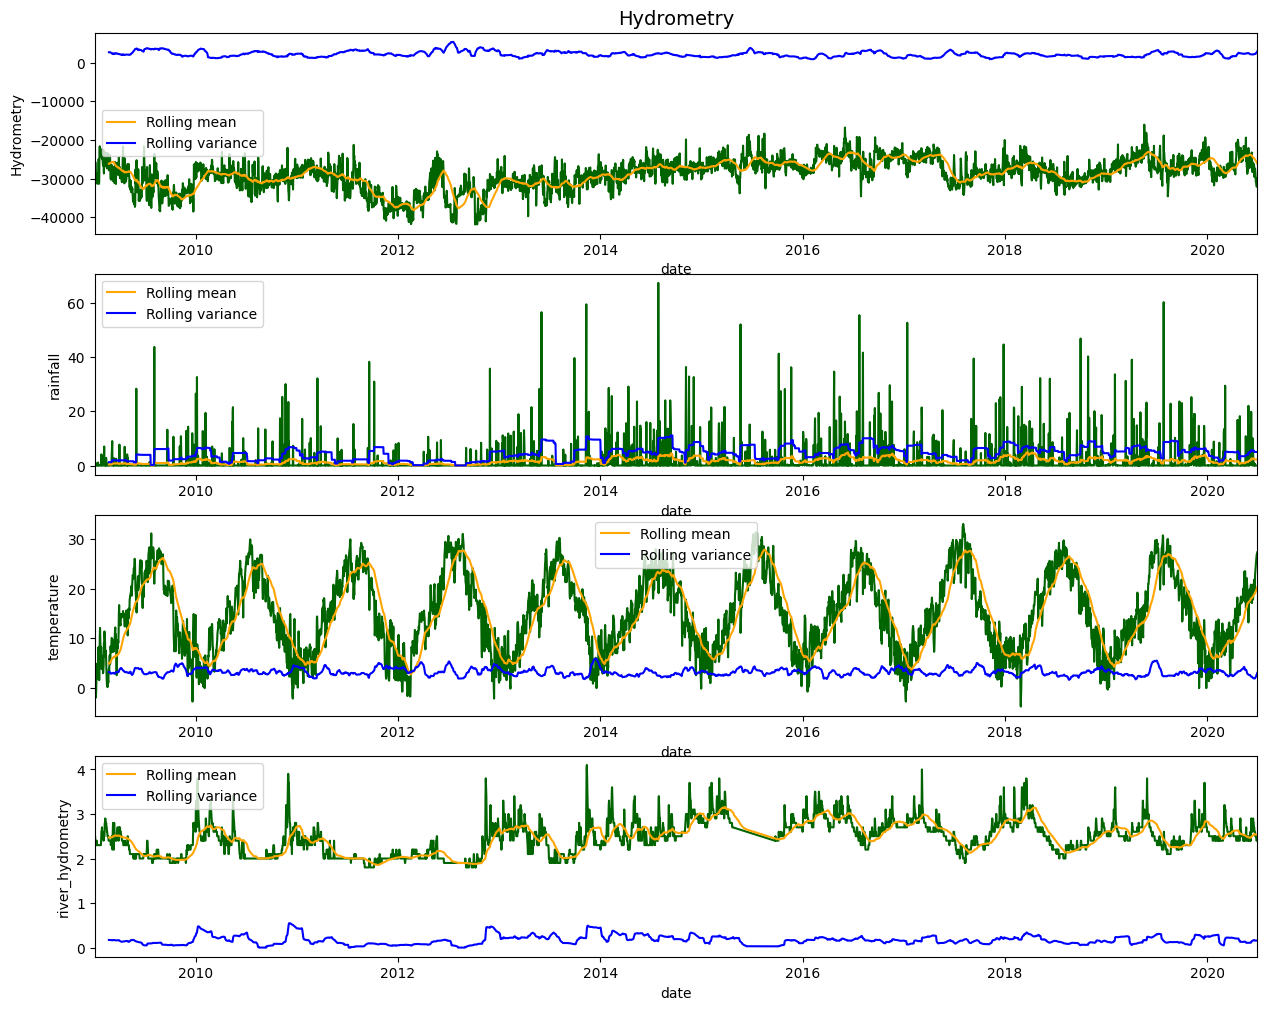

In [66]:
# Checking stationarity using Visual method
rolling_window = 52                 # our data is sampled weekly and a year has 52 week
fig, ax = plt.subplots(nrows = 4, ncols=1, figsize = (15, 12))

sns.lineplot(x = df['date'], y = df['drainage_volume'], ax = ax[0], color = 'darkgreen')
sns.lineplot(x = df['date'], y = df['drainage_volume'].rolling(rolling_window).mean(), ax = ax[0], 
             color = 'orange', label = 'Rolling mean')
sns.lineplot(x = df['date'], y = df['drainage_volume'].rolling(rolling_window).std(), ax = ax[0], 
             color = 'blue', label = 'Rolling variance')
ax[0].set_title('Volume', fontsize = 14)
ax[0].set_ylabel('Volume')

sns.lineplot(x = df['date'], y = df['rainfall'], ax = ax[1], color = 'darkgreen')
sns.lineplot(x = df['date'], y = df['rainfall'].rolling(rolling_window).mean(), ax = ax[1], 
             color = 'orange', label = 'Rolling mean')
sns.lineplot(x = df['date'], y = df['rainfall'].rolling(rolling_window).std(), ax = ax[1], 
             color = 'blue', label = 'Rolling variance')
ax[0].set_title('Rainfall', fontsize = 14)
ax[0].set_ylabel('Rainfall')

sns.lineplot(x = df['date'], y = df['temperature'], ax = ax[2], color = 'darkgreen')
sns.lineplot(x = df['date'], y = df['temperature'].rolling(rolling_window).mean(), ax = ax[2], 
             color = 'orange', label = 'Rolling mean')
sns.lineplot(x = df['date'], y = df['temperature'].rolling(rolling_window).std(), ax = ax[2], 
             color = 'blue', label = 'Rolling variance')
ax[0].set_title('Temperature', fontsize = 14)
ax[0].set_ylabel('Temperature')

sns.lineplot(x = df['date'], y = df['river_hydrometry'], ax = ax[3], color = 'darkgreen')
sns.lineplot(x = df['date'], y = df['river_hydrometry'].rolling(rolling_window).mean(), ax = ax[3], 
             color = 'orange', label = 'Rolling mean')
sns.lineplot(x = df['date'], y = df['river_hydrometry'].rolling(rolling_window).std(), ax = ax[3], 
             color = 'blue', label = 'Rolling variance')
ax[0].set_title('Hydrometry', fontsize = 14)
ax[0].set_ylabel('Hydrometry')

for i in range(4):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

Dickey Fuller

In [67]:
# Input to adfuller function is a series
adfuller(df['rainfall'].values)

(np.float64(-55.90692992415623),
 0.0,
 0,
 4198,
 {'1%': np.float64(-3.4319086715288334),
  '5%': np.float64(-2.862228735313844),
  '10%': np.float64(-2.5671366196112806)},
 np.float64(25536.555643970813))

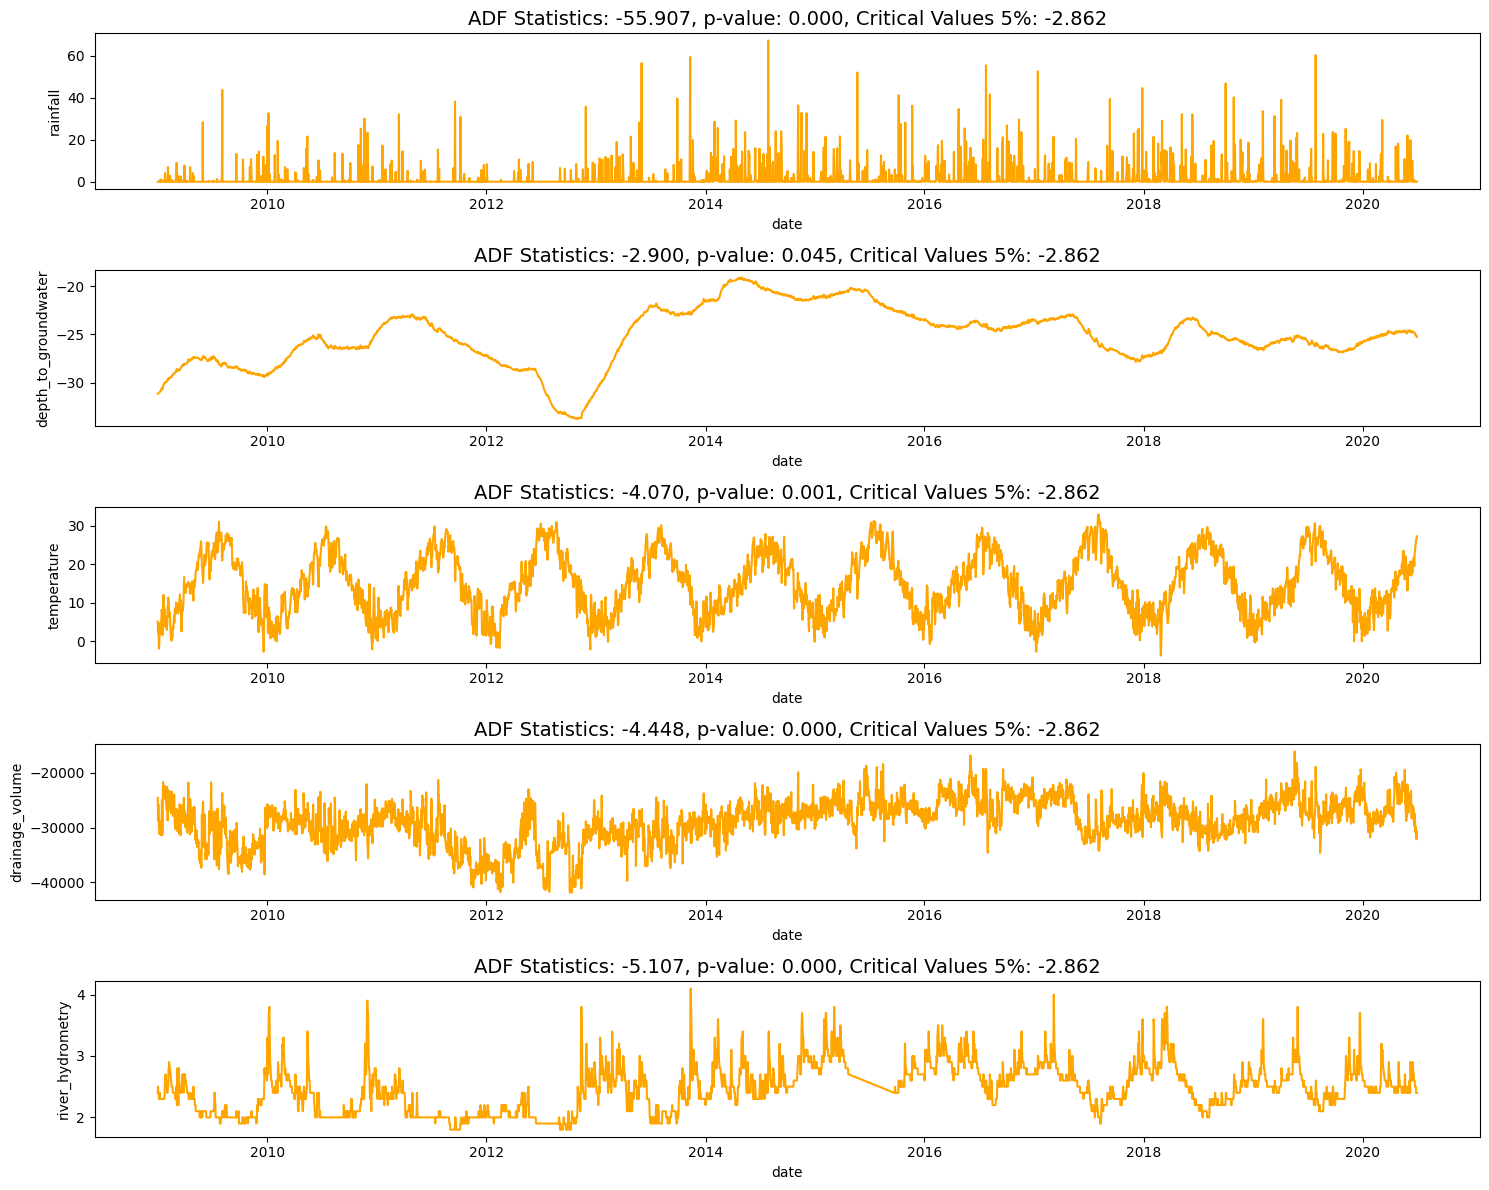

In [68]:
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize = (15, 12))

def visualize_adf_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_value = result[1]
    critical_val_5 = result[4]['5%']
    
    if (p_value < significance_level) and (adf_stat < critical_val_5):
        linecolor = 'orange'
    else:
        linecolor = 'green'
        
    sns.lineplot(x = df['date'], y = series, ax = ax, color = linecolor)
    ax.set_title(f'ADF Statistics: {adf_stat:0.3f}, p-value: {p_value:0.3f}, Critical Values 5%: {critical_val_5:0.3f}', fontsize = 14)
    ax.set_ylabel(title)
    
for i, title in enumerate(df.drop(['date'],axis=1).columns):
    visualize_adf_results(df[title], title, ax[i])
    
plt.tight_layout()
plt.show()

In [69]:


core_columns = df.drop(['date'], axis = 1).columns

for col in core_columns:
    decompose = seasonal_decompose(df[col], period = 52, model = 'additive', extrapolate_trend = 'freq')
    # It is a method to decompose a time series into a trend component, multiple seasonal components, and a residual component.
    # The seasonal decomposition is a method used in time series analysis to represent a time series as a sum 
    # (or, sometimes, a product) of three components – the linear trend, the periodic (seasonal) component, and random residuals. 
    df[f'{col}_trend'] = decompose.trend
    df[f'{col}_seasonal'] = decompose.seasonal

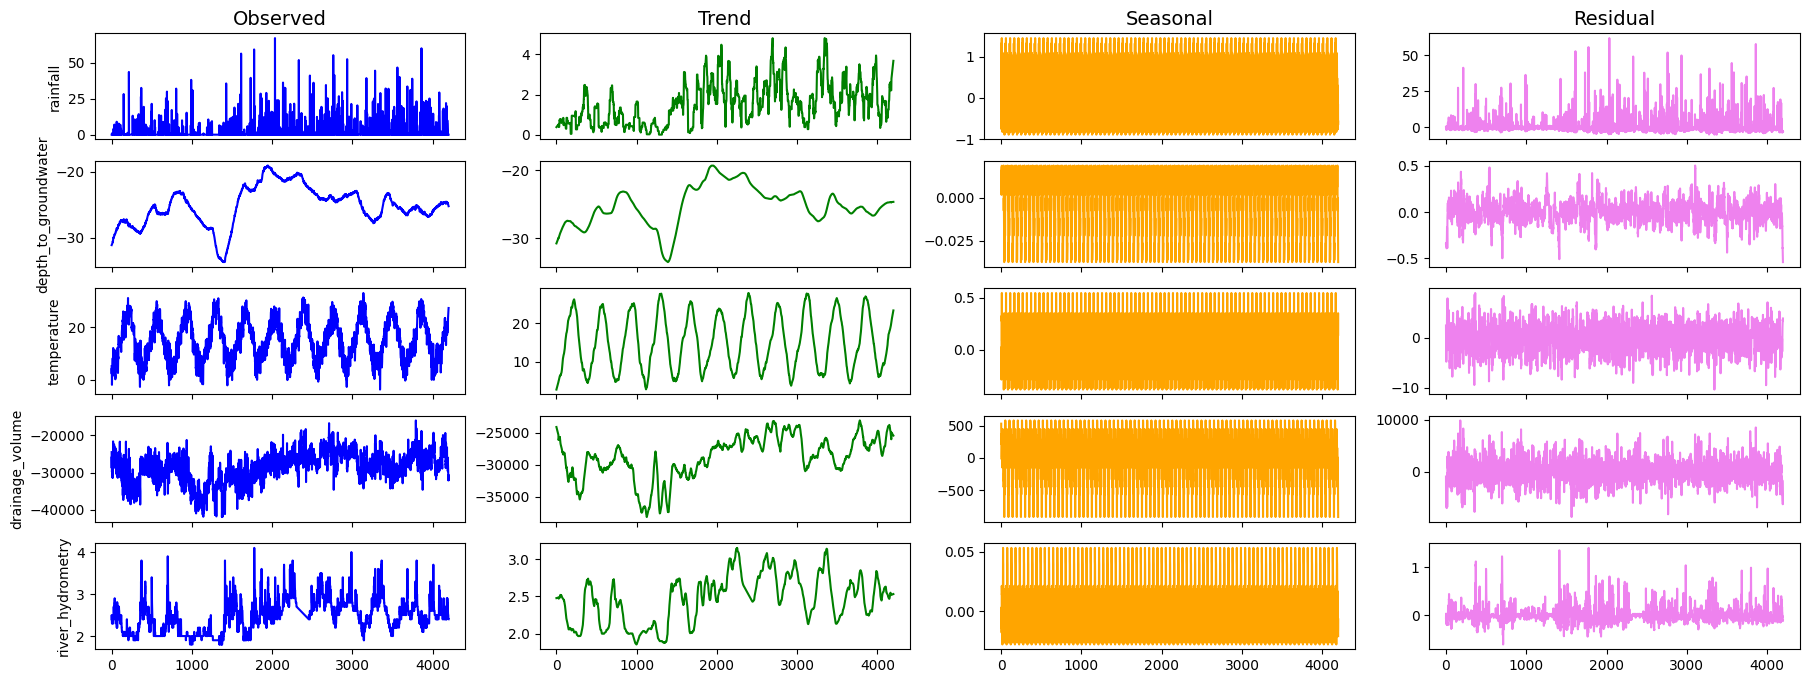

In [70]:
fig, ax = plt.subplots(nrows = 5, ncols = 4, sharex = True, figsize  = (22, 8))

def plot_seasonal_decompose(column, i):
    result = seasonal_decompose(df[column], period = 52, model = 'additive', extrapolate_trend = 'freq')
    
    ax[0, 0].set_title('Observed', fontsize = 14)
    result.observed.plot(ax = ax[i, 0], legend = False, color = 'blue')
    ax[i, 0].set_ylabel(column, fontsize = 10)
    
    ax[0, 1].set_title('Trend', fontsize = 14)
    result.trend.plot(ax = ax[i, 1], legend = False, color = 'green')
    
    ax[0, 2].set_title('Seasonal', fontsize = 14)
    result.seasonal.plot(ax = ax[i, 2], legend = False, color = 'orange')
    
    ax[0, 3].set_title('Residual', fontsize = 14)
    result.resid.plot(ax = ax[i, 3], legend = False, color = 'violet')
    

for i, col in enumerate(core_columns):
    plot_seasonal_decompose(col, i)

Autocorrelacion

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

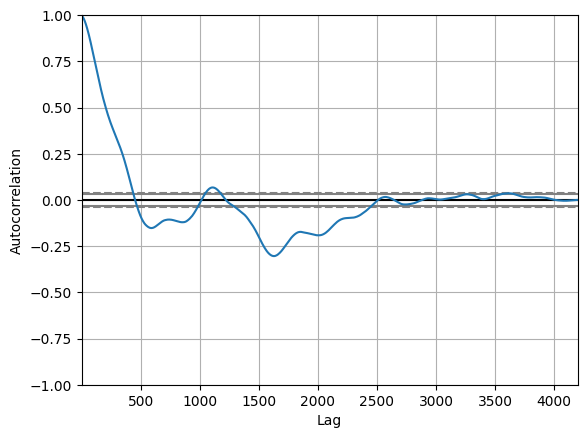

In [71]:

autocorrelation_plot(df['depth_to_groundwater'])

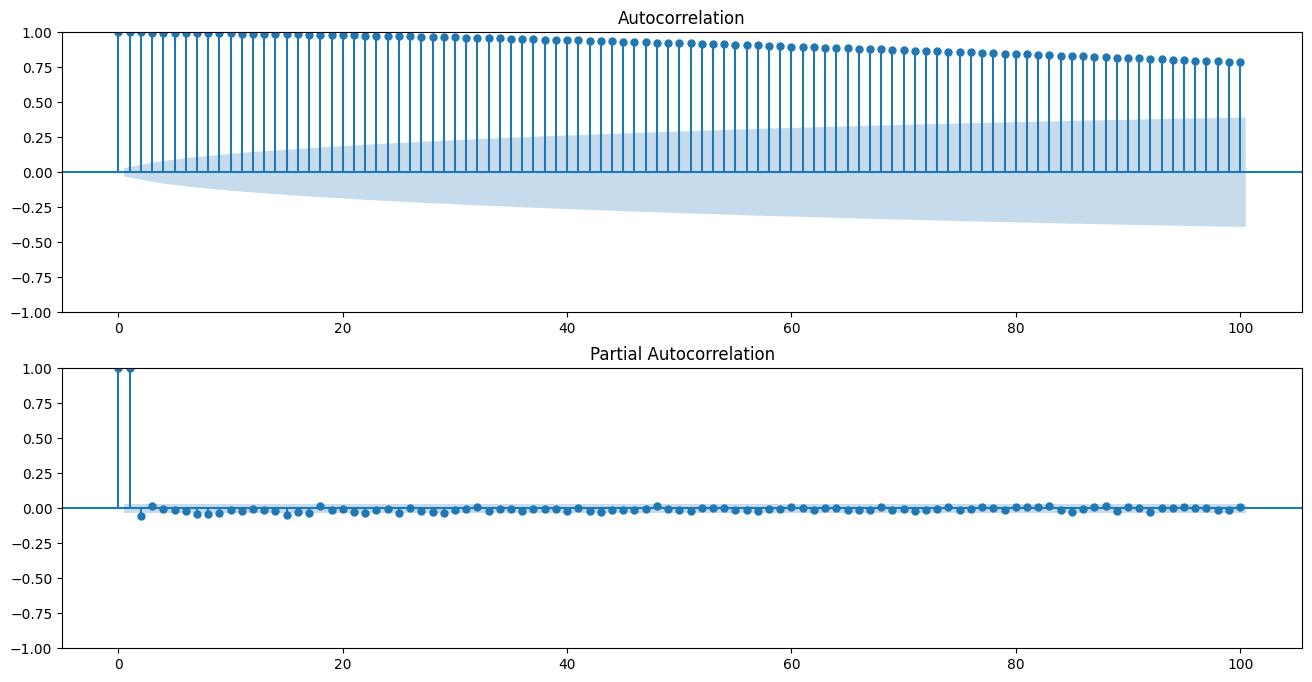

In [72]:


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16,8))

plot_acf(df['depth_to_groundwater'], lags = 100, ax = ax[0])
plot_pacf(df['depth_to_groundwater'], lags = 100, ax = ax[1])

plt.show()


Models

In [73]:

features = ['rainfall', 'temperature', 'drainage_volume', 'river_hydrometry']
targets = ['depth_to_groundwater']

train_size = int(0.85 * len(df)) 

multivariate_data = df[['date'] + targets + features].copy()
multivariate_data.columns = ['ds', 'y'] + features
# Columns named ds i.e. Date and y i.e. Target
# Forecasting models themselves identify ds, y as date and Target value respectively from data.

train = multivariate_data.iloc[:train_size, :]

# Splitting data into training and validation dataset
X_train = pd.DataFrame(multivariate_data.iloc[:train_size, [0, 2, 3, 4, 5]])
Y_train = pd.DataFrame(multivariate_data.iloc[:train_size, 1])

X_valid = pd.DataFrame(multivariate_data.iloc[train_size: , [0, 2, 3, 4, 5]])
Y_valid = pd.DataFrame(multivariate_data.iloc[train_size: , 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.14,0.0,5.2,-24530.688,2.4
1,2009-01-02,-31.11,0.0,2.3,-28785.888,2.5
2,2009-01-03,-31.07,0.0,4.4,-25766.208,2.4
3,2009-01-04,-31.05,0.0,0.8,-27919.296,2.4
4,2009-01-05,-31.01,0.0,-1.9,-29854.656,2.3


In [74]:
# Training model
model = Prophet()
for col in features:
    model.add_regressor(col)
    
# Fit model
model.fit(train)

# Predict on validation set
y_pred = model.predict(X_valid)

# Calculate error
mae = mean_absolute_error(Y_valid, y_pred['yhat'])
rmse = np.sqrt(mean_squared_error(Y_valid, y_pred['yhat']))

print(Fore.GREEN + f'MAE: {mae}')
print(Fore.BLUE + f'RMSE: {rmse}')

04:26:02 - cmdstanpy - INFO - Chain [1] start processing
04:26:04 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.247309480816853
RMSE: 1.4783971826498137


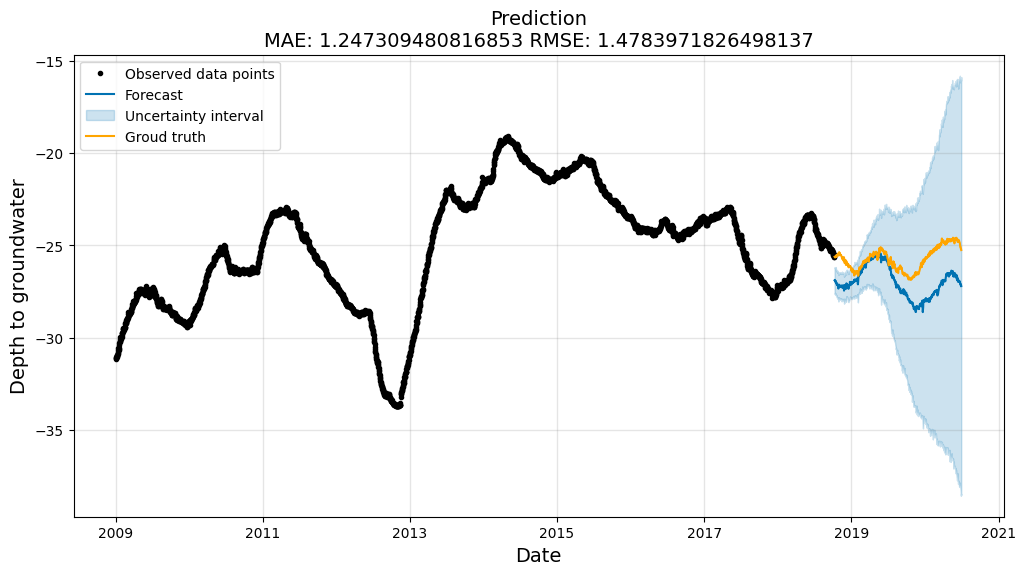

In [75]:
fig, ax = plt.subplots(1, figsize = (12, 6))

model.plot(y_pred, ax = ax)
sns.lineplot(x = X_valid['ds'], y = Y_valid['y'], ax = ax, color = 'orange', label = 'Groud truth')

ax.set_title(f'Prediction\nMAE: {mae} RMSE: {rmse}', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Depth to groundwater', fontsize = 14)

plt.show()